### Instructions

When running the notebook the first time, make sure to run all cells before making changes in the notebook. Hit Shift + Enter to run the selected cell or, in the top menu, click on: `Kernel` > `Restart Kernel and Run All Cells...` to rerun the whole notebook. If you make any changes in a cell, rerun that cell.

If you make any changes in a coding cell, rerun the notebook by `Run` > `Run Selected Cell and All Below`

In [1]:
# Import dependencies 
import sys
sys.path.append('python/')
import time
startTime = time.time()
import numpy as np
import matplotlib.pyplot as plt 
import load_galaxies as lg
import matplotlib.image as mpimg
import lmfit as lm
import scipy.integrate as si             # Python module for integration
px = 1/plt.rcParams['figure.dpi']

# Fitting

For this next activity, select one of four galaxies, import the pre-calculated rotation curves of all components and find the scaling factors by fitting the components to the measured velocity data. The Dark Matter component has two free parameters: one that changes the amplitude ($\rho_0$: central mass density) and the other that changes the shape of the curve ($r_c$: core radius). All other components (bulge,disk,gas) have only one free parameter. Let's import all the data and curves and define some functions for the fitting. 

### Choose your galaxy

![A poster. The header reads, "CHOOSE: WHICH GALAXY". Below are four boxes, each contianing a galaxy name, an image of said galaxy, and some stats about the galaxy. The options are: NGC 5005, AKA Caldwell 29, Distance: 45 MLY, Size: 55,000 LY, Constellation: Canes Venatici; NGC 5533, An Unbarred Spiral Galaxy, Distance: 177 MLY, Size: 50,000 LY, Constellation: Bootes; NGC 7814, A Bulge-Dominant Galaxy, Distance: 40 MLY, Size: 80,000 LY, Constellation: Pegasus; and NGC 891, A Disk-Dominant Galaxy, Distance: 27.3 MLY, Size: 120,000 LY, Constellation: Andromeda.](images/chooseWhichGalaxy.jpg)

In [2]:
galaxy = lg.NGC5533         # Options: lg.NGC5005 , lg.NGC5533 , lg.NGC7814 , lg.NGC0891

### Import data and curves

In [3]:
# Measured data
measured_data = galaxy['measured_data']

# Separate the columns into arrays
m_radii = galaxy['m_radii']           # Radius
m_velocities = galaxy['m_velocities'] # Velocity
m_v_errors = galaxy['m_v_errors']     # Errors in velocity

# Velocity equation for the central supermassive black hole (only for NGC 5533)
massbh = galaxy['massbh']            # Mass of the central black hole in (solar mass)
G = 4.300e-6                         # Gravitational constant (kpc/solar mass*(km/s)^2)

# Central black hole rotation curve (point-mass)
def blackhole_v(r,massbh):
    return np.sqrt((G*massbh)/r)

# Import curves of each component
# Bulge
bulge_v = galaxy['bulge']['spline']
# Disk
disk_v = galaxy['disk']['spline']
# Gas
gas_v = galaxy['gas']['spline']

# For Galaxy NGC 5533, we can import a "confidence band" data which increases the fitting confidence
if galaxy['galaxyname'] == 'NGC 5533':
    greyb_bottom = galaxy['n_band_btm']
    greyb_top = galaxy['n_band_top']
    conf_band = galaxy['n_v_bandwidth']

### Calculate the rotational velocity of the Dark Matter halo component

For more details, see `04_Plotting_Rotation_Curves.ipynb`.

In [4]:
# Set parameters
rho0 = galaxy['rho0']   # central mass density (in solar mass/kpc^3)
rc = galaxy['rc']       # core radius (in kpc)

# Equation for dark matter halo velocity
def halo_v(r,rho0,rc):
    v = np.sqrt(4*np.pi*G*rho0*rc**2*(1 - rc/r * np.arctan(r/rc)))
    return v

### Define functions and values

In [5]:
# Express weight
if galaxy['galaxyname'] == 'NGC 5533':    # For Galaxy NGC 5533, we can import a "confidence band" data which increases the fitting confidence
    weighdata = 1/np.sqrt((m_v_errors**2) + (conf_band**2))
else:
    weighdata = 1/m_v_errors

# Define function for total velocity with prefactors (scaling parameters)
def total_v_pref(r,massbh,bulge_pref,disk_pref,gas_pref,rho0,rc):
    return np.sqrt(blackhole_v(r,massbh)**2
                   + (bulge_pref * bulge_v(r))**2 
                   + (disk_pref * disk_v(r))**2 
                   + (gas_pref * gas_v(r))**2
                   + (halo_v(r,rho0,rc)**2))

# Define function for total velocity with prefactors (scaling parameters), with no dark matter
def total_v_pref_noDM(r,massbh,bulge_pref,disk_pref,gas_pref):
    return np.sqrt(blackhole_v(r,massbh)**2
                   + (bulge_pref * bulge_v(r))**2 
                   + (disk_pref * disk_v(r))**2 
                   + (gas_pref * gas_v(r))**2)

### Fitting parameters

<div class="alert-info">Activity 1)</div>

>Free parameters can be varied during the fit. Turn these off and on by changing `vary=True` to `vary=False` or `vary=False` to `vary=True` to see how your results of the fit change in the plot and for the fit statistics displayed below. Notice that the Dark Matter halo has two free parameters: `rho0` and `rc` that changes the amplitude and the shape, respectively. Vary one of these parameters and fix (`vary=False`) the other and note the difference.

<div class="alert-info">Activity 2)</div>

>Now, use the total velocity equation without Dark Matter (`total_v_pref_noDM` equation) and find the fitting parameters. Make sure to comment out (put a `#` in front of) the lines: `f_params.add('rc'...` and `f_params.add('rho0'...` because these are parameters for the Dark Matter halo.<br>

_Python help: to use a different equation for the fitting, change the line: f\_mod = lm.Model(equation)._

In [6]:
# Setup 
f_mod = lm.Model(total_v_pref)               # using the equation with Dark Matter for the fitting
#f_mod = lm.Model(total_v_pref_noDM)         # using the equation without Dark Matter for the fitting
f_params = f_mod.make_params()               # define parameters

# Black Hole
f_params.add('massbh',     vary=True,  value=massbh, min=1.0e8)#0.1*massbh)  # mass of central black hole

# Bulge
f_params.add('bulge_pref', vary=True,  value=1,      min=0,max=100)   # bulge prefactor

# Disk
f_params.add('disk_pref',  vary=True,  value=1,      min=0,max=100)   # disk prefactor

# Gas
f_params.add('gas_pref',   vary=False, value=1)                       # gas prefactor

# Dark Matter halo
f_params.add('rho0',       vary=True,  value=rho0,   min=0)           # central halo density (solar mass/kpc^3)
f_params.add('rc',         vary=True,  value=rc,     min=0.1)         # core radius (kpc)

### Do the fitting

Let Python calculate the fitting parameters and display the fit statistics. Examine the results for the values of each variable. 

In [7]:
#NBVAL_IGNORE_OUTPUT
#Because there is some randomness to the fit itself
f_fit = f_mod.fit(m_velocities, f_params, r = m_radii, weights = weighdata)

# Show fit statistics
f_fit

#### Chi-square $\chi^2$:

The chi-squared value is an indication of the goodness of your fit or how well the observed and expected data agree. A zero chi-squared value is a perfect fit (data points connected with a line). This may seem ideal on the surface, but it can indicate a nonphysical system and is highly unlikely. The value of chi-squared is "the number of observed points minus the number of parameters computed from the data and used in the calculation" (Taylor, 1997).


#### Reduced chi-square:
The reduced chi-squared value is the chi-squared value divided by the degrees of freedom. In general, we would want this value to be close to 1 to be a good fit. 

### Define parameters for plotting

In [8]:
# Define curve of the best fit
bestf = f_fit.best_fit

# Define radius for plotting
r_lowerlim = np.min(m_radii)                       # limit the radius to the min value of the measured radius
if r_lowerlim == 0:                                # getting rid of dividing by zero error
    r_lowerlim = 0.01
r_upperlim = np.max(m_radii)                       # limit the radius to the max value of the measured radius
r = np.linspace(r_lowerlim,r_upperlim,100)         # starting from zero results in a divide by zero error

### Plot result

<div class="alert-info">Activity 3)</div>

> Zoom into the graph by changing the limits of the x-axis to see how well the total curve lines up with the measured points. For example: `plt.xlim(0,5)`

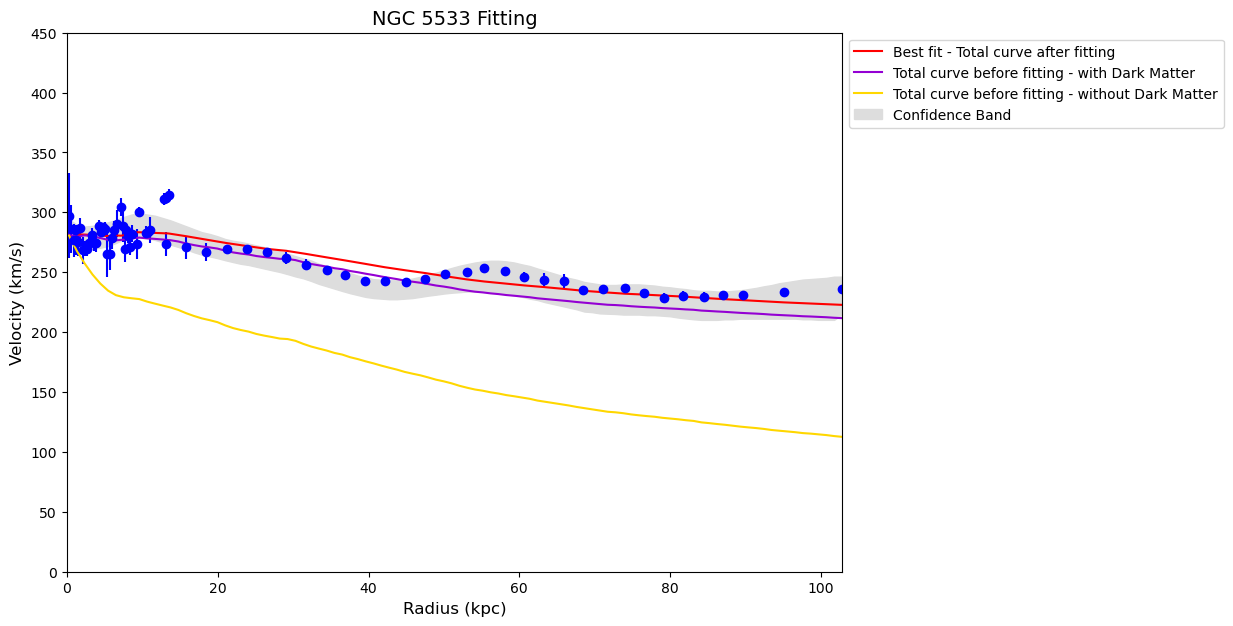

In [9]:
plt.figure(figsize=(1000*px,700*px))                                     # size of the plot
plt.title('{} Fitting'.format(galaxy['galaxyname']), fontsize=14)  # giving the plot a title
plt.xlabel('Radius (kpc)', fontsize=12)                            # labeling the x-axis
plt.ylabel('Velocity (km/s)', fontsize=12)                         # labeling the y-axis
plt.xlim(0,r_upperlim)                                             # limits of the x-axis
plt.ylim(0,450)                                                    # limits of the y-axis
plt.errorbar(m_radii,m_velocities,yerr=m_v_errors,fmt='bo')        # plot measured data points
plt.plot(m_radii,bestf, color='r', label='Best fit - Total curve after fitting')    # plot the best fit to the data points
plt.plot(r,total_v_pref(r,massbh=massbh,bulge_pref=1,disk_pref=1,gas_pref=1,rho0=rho0,rc=rc), \
         color='darkviolet', label='Total curve before fitting - with Dark Matter')   
plt.plot(r,total_v_pref_noDM(r,massbh=massbh,bulge_pref=1,disk_pref=1,gas_pref=1), \
         color='gold', label='Total curve before fitting - without Dark Matter')

# Galaxy NGC 5533 has a confidence band that we can plot and calculate for a better fitting value
if galaxy['galaxyname'] == 'NGC 5533':
    plt.fill_between(r,greyb_bottom(r),greyb_top(r),color='#dddddd',label="Confidence Band")
    
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

### Calculate the total mass of the Dark Matter

<div class="alert-info">Activity 4)</div>

>Using the equation for the mass as a function of radius, $M(r)$ (see _04\_Plotting\_Rotation\_Curves.ipynb_ module), calculate the total mass of Dark Matter enclosed within the given radius. For the mass density profile, $\rho (r)$ function, use the isothermal density distribution.

<div class="alert-info">Activity 5)</div>

>Change the radius interval to see how much the total mass of the Dark Matter enclosed in that radius changes.<br>

_Python help: Modify the inner radius by changing the line: `r1 = `, the outer radius by changing the line: `r2 = `_

In [10]:
# Set parameters
rho0 = galaxy['rho0']   # central mass density (in solar mass/kpc^3)
rc = galaxy['rc']       # core radius (in kpc)

# Radius at which we are calculating the total mass enclosed
r1 = 0    # inner radius, in kpc
r2 = 25   # outer radius, in kpc

# Equation for isothermal density
def density_iso(r):
    density = rho0 * (1 + (r/rc)**2)**(-1)
    return density

# Equation for mass as a function of radius
def mass_function(r):
    mass = 4 * np.pi * density_iso(r) * r**2
    return mass

# Integrate to calculate total mass enclosed
totalmass = si.quad(mass_function, r1, r2)[0]

# Total mass
print("Total mass of the Dark Matter between the radius values of {} and {} kpc is {:.3e} solar masses.".format(r1,r2,totalmass))

Total mass of the Dark Matter between the radius values of 0 and 25 kpc is 1.747e+11 solar masses.


<div class="alert-info">Activity 6)</div>

>Out of the four galaxies, which one has more Dark Matter within the given radius?<br>

In [11]:
#NBVAL_IGNORE_OUTPUT
#Because the timing won't be exactly the same each time.
# Time
executionTime = (time.time() - startTime)
ttt=executionTime/60
print(f'Execution time: {ttt:.2f} minutes')

Execution time: 0.07 minutes


### References <br>

>Casertano, Stefano. **Rotation curve of the edge-on spiral galaxy NGC 5907: disc and halo masses.** _Monthly Notices of the Royal Astronomical Society_ 203, no. 3 (1983): 735-747. https://doi.org/10.1093/mnras/203.3.735. <br><br>
>Fraternali, F., R. Sancisi, and P. Kamphuis. **A Tale of Two Galaxies: Light and Mass in NGC 891 and NGC 7814.** Astronomy &amp; Astrophysics 531 (June 13, 2011). https://doi.org/10.1051/0004-6361/201116634.<br><br> 
>Jimenez, Raul, Licia Verde, and S. Peng Oh. **Dark halo properties from rotation curves.** _Monthly Notices of the Royal Astronomical Society_ 339, no. 1 (2003): 243-259. https://doi.org/10.1046/j.1365-8711.2003.06165.x. <br><br>
>Kapteyn Institute. (n.d.). Groningen Image Processing System. **GIPSY, the GRONINGEN image processing system.** https://www.astro.rug.nl/~gipsy/index.html. <br><br>
>Karukes, E. V., P. Salucci, and Gianfranco Gentile. **The dark matter distribution in the spiral NGC 3198 out to 0.22 $R_{vir}$.** _Astronomy & Astrophysics_ 578 (2015): A13. https://doi.org/10.1051/0004-6361/201425339. <br><br>
>Noordermeer, Edo. **The rotation curves of flattened Sérsic bulges.** _Monthly Notices of the Royal Astronomical Society_ 385, no. 3 (2007): 1359-1364. https://doi.org/10.1111/j.1365-2966.2008.12837.x. <br><br>
>Richards, Emily E., L. van Zee, K. L. Barnes, S. Staudaher, D. A. Dale, T. T. Braun, D. C. Wavle, et al. **Baryonic Distributions in the Dark Matter Halo of NGC 5005.** Monthly Notices of the Royal Astronomical Society 449, no. 4 (June 1, 2015): 3981–96. https://doi.org/10.1093/mnras/stv568. <br><br>
>Taylor, John Robert. **An Introduction to Error Analysis: The Study of Uncertainties in Physical Measurements.** 2nd ed. United States of America: University Science Books, 1997. 
***